# Project: AI gamer for LunarLander-v2

### Import dependencies

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange
import pickle
import time
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Initialize the environment

In [157]:
env = gym.make('MountainCar-v0')

### Create Q-learning model

In [116]:
class Q_learning:

    def __init__(self, environment, policy='eps_greedy', max_steps=500, learning_rate=1e-3, discount_rate=0.9, epsilon_range=(0.05,0.9), decay_rate=0.0005):
        self._environment = environment
        self._max_steps = max_steps
        self._learning_rate = learning_rate
        self._discount_Rate = discount_rate
        self._epsilon_range = epsilon_range
        self._latest_epsilon = epsilon_range[1]
        self._decay_rate = decay_rate
        self._policy = policy
        self._Q_table_segment_range = 50
        self._Q_table = self.Initilize_Q_table()

    def __params__(self):
        print('Model parameters:')
        print(f'Learning rate: {self._learning_rate}')
        print(f'Discount rate: {self._discount_Rate}')
        print(f'Min epsilon - max epsilon: {self._epsilon_range[0]} - {self._epsilon_range[1]}')
        print(f'Decay rate: {self._decay_rate}\n')

    def Initilize_Q_table(self):
        possible_states = self._environment.observation_space.shape[0]
        possible_actions = self._environment.action_space.n
        state_size = (self._Q_table_segment_range,) * possible_states
        action_size = (possible_actions,)
        Q_table_size = state_size + action_size
        Q_table = np.random.randint(0, self._Q_table_segment_range, size=Q_table_size)
        return Q_table

    def get_epsilon(self, current_episode):
        min_epsilon, max_epsilon = self._epsilon_range
        epsilon_range = max_epsilon - min_epsilon
        epsilon = min_epsilon + epsilon_range*np.exp(-self._decay_rate*current_episode)
        return epsilon

    # Convert environment state into Q-table values states
    def Q_table_state_conversion(self, state, state_size):

        # Initialize observation space segment range
        observation_space_scale = np.ones(state_size, dtype=int)*(self._Q_table_segment_range - 1)

        # State normalization
        normalized_state = (state - self._environment.observation_space.low) / (self._environment.observation_space.high - self._environment.observation_space.low)
        # Scaling state into Q-table scale range
        scaled_state = normalized_state*observation_space_scale

        # The return value is state values vector of different features, for each features the value range 
        # is scaled into integer range, which can be accessed as the corresponding indices
        # The tuple type is to count the state values of features as the defined indices pointed to the corresponding actions
        return tuple(np.round(scaled_state).astype(int))
    
    def update_Q_table(self, current_Q_value, Q_table_index, reward, next_Q_value_state):
        # Update new Q value
        new_Q_value = (1 - self._learning_rate)*current_Q_value + self._learning_rate*(reward + self._discount_Rate*np.max(self._Q_table[next_Q_value_state]))
        # Update Q-table
        self._Q_table[Q_table_index] = int(new_Q_value)
   
    def epsilon_greedy_policy(self, Q_table_state, epsilon):
        prob_score = np.random.uniform(0,1)
        if prob_score > epsilon:
            action = np.argmax(self._Q_table[Q_table_state])
        else:
            action = self._environment.action_space.sample()
        return action

    def greedy_policy(self, Q_table_state):
        return np.argmax(self._Q_table[Q_table_state])

    def load_Q_table(self, filename):
        with open(filename, 'rb') as f:
            self._Q_table = pickle.load(f)

    def train(self, epochs=200, truncated=True, early_stopping=True, verbose=True):
        # Initialize new model
        self._Q_table = self.Initilize_Q_table()

        if not os.path.exists('./Results/'):
            os.makedirs('./Results/')

        # Reset the environment
        reset_state = self._environment.reset()
        state_size = reset_state[0].shape

        max_reward_score = 0

        exceed_limit_count = 0

        show_progress = False

        for epoch in trange(epochs):
            # Get the epsilon value
            epsilon = self.get_epsilon(epoch)
            self._latest_epsilon = epsilon

            # Reset the environment
            current_state = self._environment.reset()[0]
            # Get state for Q table
            Q_value_state = self.Q_table_state_conversion(current_state, state_size)

            terminate = False
            reward_score = 0
            
            if truncated:
                max_step = self._max_steps
            else:
                max_step = int(1e10)
            
            start = time.time()
            for step in range(max_step):

                # Get corresponding action for the state
                if self._policy == 'eps_greedy':
                    action = self.epsilon_greedy_policy(Q_value_state, epsilon)
                elif self._policy == 'greedy':
                    action = self.greedy_policy(Q_value_state)

                # Perform action
                new_state, reward, terminate, truncated, info = self._environment.step(action)

                # Recalculate reward after steps
                reward_score += reward

                # Get new state for Q table
                Q_value_new_state = self.Q_table_state_conversion(new_state, state_size)

                # Get index of the (current state, action) in the Q-table
                Q_table_index = Q_value_state + (action,)

                # Get Q value of the (current state, action) in the Q-table
                current_Q_value = self._Q_table[Q_table_index]

                # Update Q value of the (current state, action) in the Q-table
                self.update_Q_table(current_Q_value, Q_table_index, reward, Q_value_new_state)

                if terminate:
                    if epoch == 0:
                        max_reward_score = reward_score
                        print('test')
                        
                        # Save to the best model
                        with open('./Results/best.pkl', 'wb') as f:
                            pickle.dump(self._Q_table, f)
                    else:
                        if reward_score > max_reward_score:
                            max_reward_score = reward_score

                            # Reset the counter
                            exceed_limit_count = 0                

                            # Save to the best model
                            with open('./Results/best.pkl', 'wb') as f:
                                pickle.dump(self._Q_table, f)
                        
                    # Update the latest model
                    with open('./Results/last.pkl', 'wb') as f:
                        pickle.dump(self._Q_table, f)

                    if verbose:
                        avarage_time = time.time() - start
                        seconds = int(avarage_time)
                        ms_seconds = int((avarage_time - seconds)*1e3)
                        print(f'Epoch {epoch}/{epochs - 1}:\t[===================================]\t- {seconds}s {ms_seconds}ms/{step + 1}steps\t- reward: {reward_score:.2f}')
                        show_progress = True

                    break

                Q_value_state = Q_value_new_state

            # Update the latest model
            with open('./Results/last.pkl', 'wb') as f:
                pickle.dump(self._Q_table, f)

            if verbose and not show_progress:
                avarage_time = time.time() - start
                seconds = int(avarage_time)
                ms_seconds = int((avarage_time - seconds)*1e3)
                print(f'Epoch {epoch}/{epochs - 1}:\t[===================================]\t- {seconds}s {ms_seconds}ms/{step + 1}steps\t- reward: {reward_score:.2f}')

            elif verbose and show_progress:
                show_progress = False

            if reward_score < max_reward_score:
                exceed_limit_count += 1
            if exceed_limit_count > 5 and early_stopping:
                print('Training session is stopped due to no further improvement.')
                break

        print('Best model is save to: ./Results/best.pkl')

    def test_model(self, show_progress=False):
        if show_progress:
            self._environment.unwrapped.render_mode = 'human'
        else:
            self._environment.unwrapped.render_mode = 'rgb_array'

        # Resset the environment
        current_state = self._environment.reset()[0]
        state_size = current_state.shape

        terminate = False
        step = -1
        while not terminate:
            step += 1

            # Get Q value of the current state
            Q_value_state = self.Q_table_state_conversion(current_state, state_size)

            # Get corresponding action from the Q table
            if self._policy == 'eps_greedy':
                action = self.epsilon_greedy_policy(Q_value_state, self._latest_epsilon)
            elif self._policy == 'greedy':
                action = self.greedy_policy(Q_value_state)

            # Perform action
            new_state, reward, terminate, truncated, info = self._environment.step(action)

            # Render the action
            if show_progress:
                self._environment.render()

            current_state = new_state
        
        if not show_progress:
            result = self._environment.render()
            plt.imshow(result)
            plt.axis('off')
            plt.show()

        self._environment.close()
        print(f'Reach the goal position at step {step}')

In [158]:
# Initialize Q-learning model
model = Q_learning(environment=env, policy='eps_greedy', max_steps=50000, learning_rate=5e-1, discount_rate=0.9, epsilon_range=(0.05,0.9), decay_rate=0.05)

### Train model

In [201]:
model.train(20, truncated=True, early_stopping=True)

  0%|          | 0/20 [00:00<?, ?it/s]

test
Epoch 0/19:	[===================================]	- 6s 115ms/38273steps	- reward: -38273.00
Epoch 1/19:	[===================================]	- 0s 320ms/1890steps	- reward: -1890.00
Epoch 2/19:	[===================================]	- 0s 705ms/4574steps	- reward: -4574.00
Epoch 3/19:	[===================================]	- 1s 31ms/6147steps	- reward: -6147.00
Epoch 4/19:	[===================================]	- 0s 537ms/2898steps	- reward: -2898.00
Epoch 5/19:	[===================================]	- 0s 292ms/1656steps	- reward: -1656.00
Epoch 6/19:	[===================================]	- 0s 579ms/3120steps	- reward: -3120.00
Epoch 7/19:	[===================================]	- 1s 64ms/5689steps	- reward: -5689.00
Epoch 8/19:	[===================================]	- 0s 661ms/3816steps	- reward: -3816.00
Epoch 9/19:	[===================================]	- 0s 463ms/2711steps	- reward: -2711.00
Epoch 10/19:	[===================================]	- 0s 278ms/1449steps	- reward: -1449.00
Epoc

### Test model

In [202]:
model.load_Q_table('./Results/best.pkl')

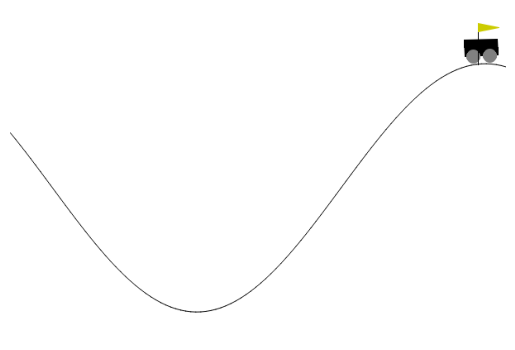

Reach the goal position at step 1710


In [204]:
model.test_model(show_progress=False)